In [2]:
!pip install keras
!pip install keras_tuner
!pip install tensorflow
!pip install scikeras
!pip install seaborn

In [12]:
#Important librabies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, Input, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix, accuracy_score, f1_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel, mutual_info_regression
from sklearn.impute import KNNImputer
from xgboost import XGBRegressor, plot_importance


Bioinformatics part
1.   Velvet
2.   Prodigal
3.   Blast file preprocessing



In [ ]:
#1---------------
'''
velveth output 31 -shortPaired -fastq L_monocytogenes_03EB210LM_1_R1.fastq  -fastq L_monocytogenes_03EB210LM_1_R2.fastq
'''

#2---------------
'''
prodigal -i contigs.fa -a output_protein_file -d output_nucleotide_file -f gff
'''

#3---------------
import pandas as pd

# Function to parse the protein file and map each node to its sequence
def parse_protein_file(protein_file_path):
    node_sequences = {}
    current_node = None
    current_sequence = []

    with open(protein_file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if line.startswith('>'):  # This is a new node header
                # Save the previous node and its sequence if exists
                if current_node:
                    node_sequences[current_node] = ''.join(current_sequence)
                # Extract the node name from the header
                current_node = line.split(' ')[0][1:]  # Removes '>' and trailing info
                current_sequence = []  # Reset sequence for the new node
            else:
                current_sequence.append(line)  # Add to the current sequence

        # Add the last node after finishing the loop
        if current_node:
            node_sequences[current_node] = ''.join(current_sequence)

    return node_sequences

# Parse the CSV file to get the list of nodes to extract
def extract_nodes_from_csv(csv_data):
    node_list = []
    for locations in csv_data['Unnamed: 3'][2:]:  # Skip headers and start from data rows
        if pd.notna(locations):
            # Split multiple locations by ";"
            nodes = locations.split(';')
            node_list.extend([node.strip() for node in nodes if node.strip()])
    return node_list

# Extract the sequences of the required nodes and save to a new file
def extract_sequences_for_nodes(node_sequences, node_list, output_file_path):
    with open(output_file_path, 'w') as output_file:
        for node in node_list:
            if node in node_sequences:
                output_file.write(f'>{node}\n{node_sequences[node]}\n')

# Load the CSV file
csv_file_path = '/content/VFDB_Dec_24-4420904943.csv'
csv_data = pd.read_csv(csv_file_path)

# Define file paths
protein_file_path = "/content/ERS1375118_protein_file"
output_file_path = '/content/untitled'

# Execute the extraction process
node_sequences = parse_protein_file(protein_file_path)  # Parse protein file to get sequences
node_list = extract_nodes_from_csv(csv_data)  # Extract nodes list from CSV
extract_sequences_for_nodes(node_sequences, node_list, output_file_path)  # Save to output file

FINAL DATA file loading

In [5]:
# Load the dataset
data = pd.read_csv('/content/FINAL_DATA.csv')
data = data.drop('Strain', axis=1)

# Input (features) and output (target)
X = data.drop('Food Frequency', axis=1)
y = data['Food Frequency']

Feature Selection and Extraction
1. Frequency ratio
2. Percent of unique values
3. Minmax normalizer
4. PCA And train, test split
5. Heatmap


            Column  Frequency Ratio
0             dltA         2.923077
1             fbpA         2.031250
2              ami         1.521739
3             inlF         3.238095
4             inlJ         2.307692
5              lap         7.812500
6             lapB         1.065217
7              bsh         2.450000
8              mpl         1.062500
9             plcB         2.500000
10            plcA         2.050000
11             stp         1.810811
12            inlC         1.155172
13            inlK         2.600000
14            lntA         1.176471
15           lplA1         5.952381
16            oppA         8.705882
17           prsA2         2.138889
18             hpt         1.315789
19             aut         5.272727
20        iap/cwhA         3.375000
21            gtcA         7.812500
22            inlA         1.045455
23            inlB         2.833333
24            inlP         1.150000
25            lpeA         3.000000
26             vip         2

<Axes: >

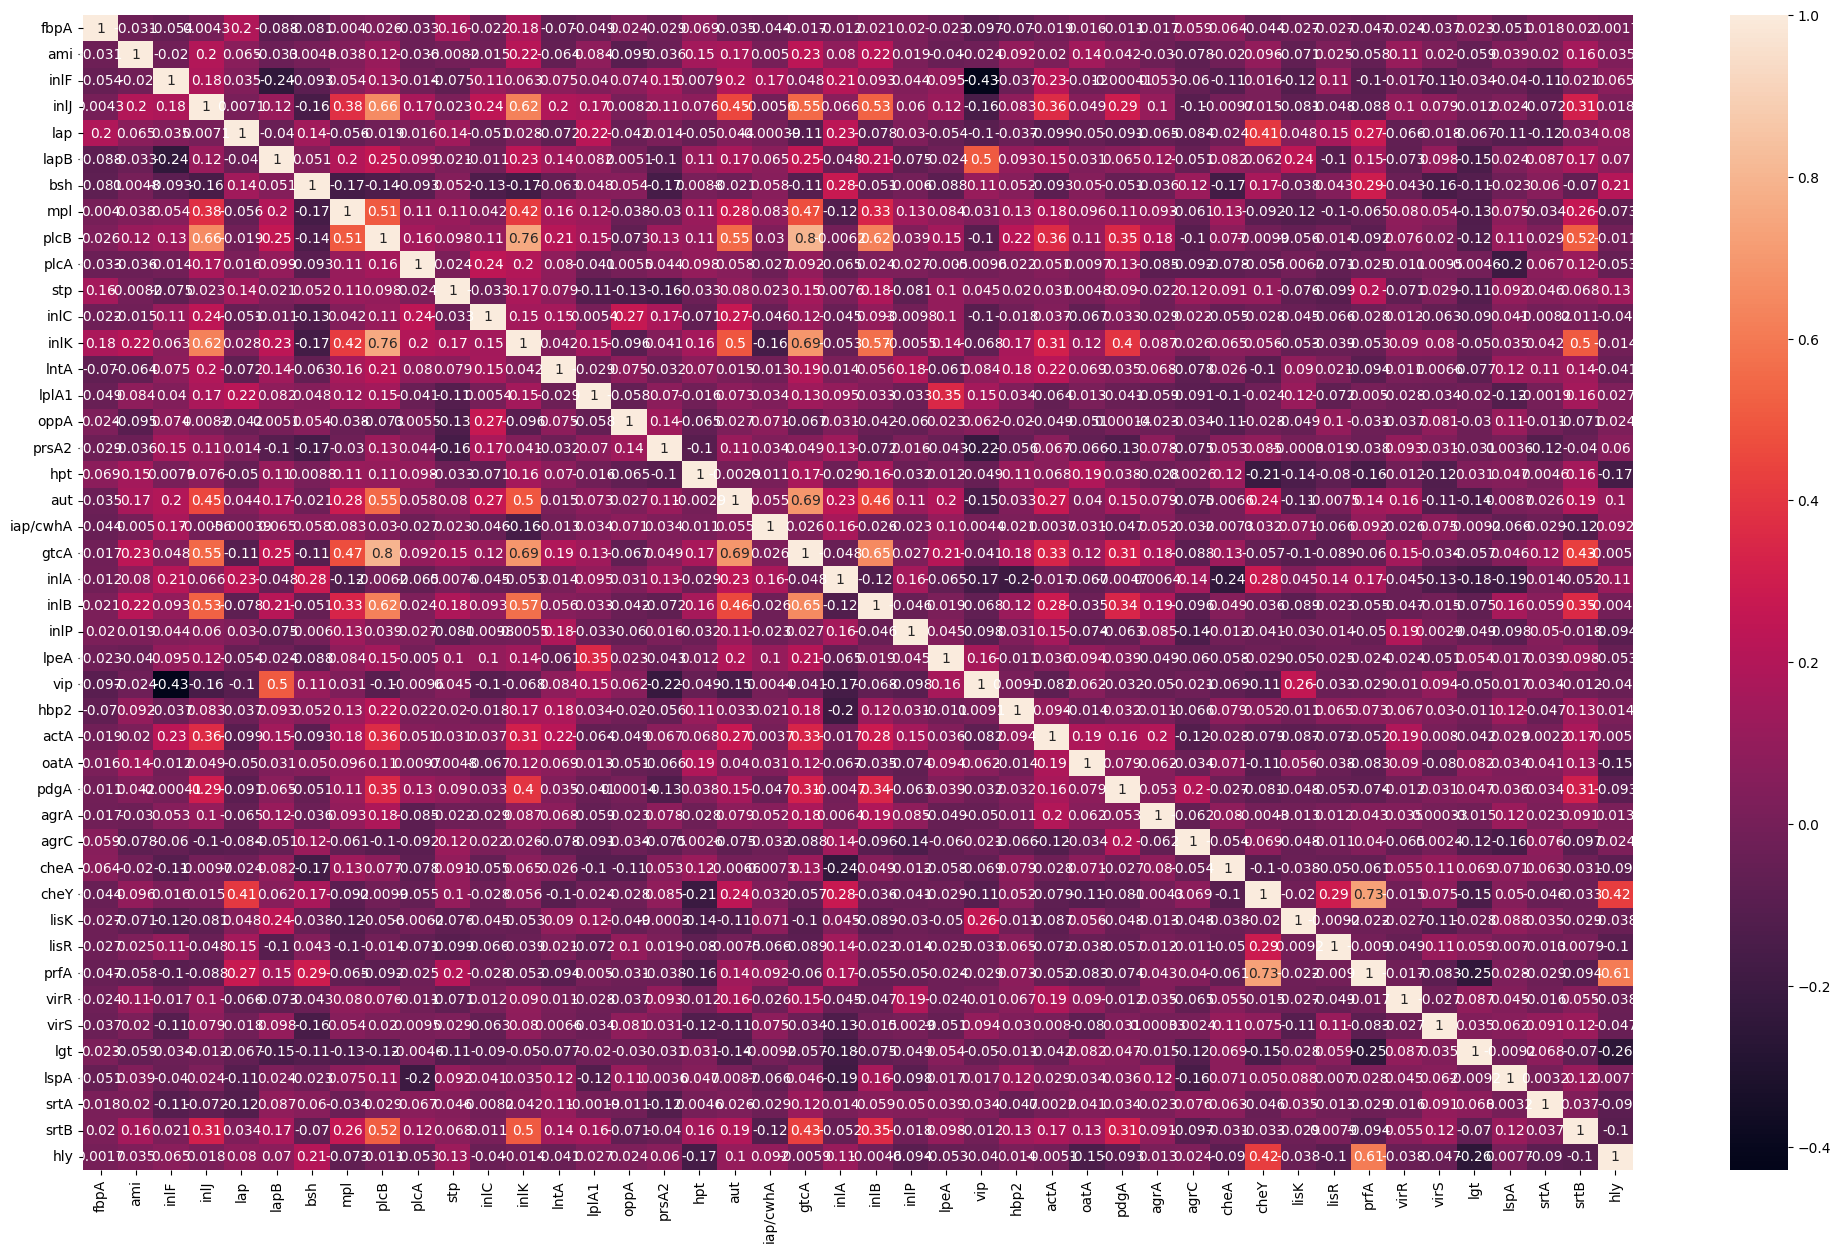

In [16]:
#1------------------------------------------------------------------------------------------ Frequency Ratio
def calculate_frequency_ratio(column):
    frequencies = column.value_counts()
    if len(frequencies) < 2:
        return None
    # Calculate the ratio of the most frequent to the second most frequent
    return frequencies.iloc[0] / frequencies.iloc[1]

# Apply the function to each column
frequency_ratios = {}
for col in data.columns:
    if col not in ['Strain']:  # Exclude non-relevant columns non num
        frequency_ratios[col] = calculate_frequency_ratio(data[col])

# Convert the results into a DataFrame
frequency_ratios_df = pd.DataFrame.from_dict(frequency_ratios, orient='index', columns=['Frequency Ratio'])
frequency_ratios_df.reset_index(inplace=True)
frequency_ratios_df.rename(columns={'index': 'Column'}, inplace=True)

# Print the frequency ratios table
print(frequency_ratios_df)

# Save the frequency ratios table to a CSV file
output_file_path = 'Frequency_Ratios.csv'
frequency_ratios_df.to_csv(output_file_path, index=False)

print(f"The table has been saved as 'Frequency_Ratios.csv' at: {output_file_path}")


#2---------------------------------------------------------------------------------Percent of unique Values

percent_unique=data.nunique()/len(data)*100
results=percent_unique.reset_index()
results.columns=['Column_name','percent']
results.to_csv('percent_unique_values.csv',index=False)

# Normalize the input data using MinMaxScaler
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(X)

#4---------------------------------------------------------------------------------------------------PCA

# Apply PCA for dimensionality reduction
pca = PCA(n_components=5) #change n-components
x_pca = pca.fit_transform(x_scaled)

# Splitting data into training and testing datasets
xtrain, xtest, ytrain, ytest = train_test_split(x_scaled, y, test_size=0.3, random_state=0) #Change 'x_pca' into 'x_scaled' and vice versa to change train split between split using PCA or all features

#
df = data.iloc[:, 1:-1]
CorrMat = df.corr()

plt.figure(figsize = (25,15))

sns.heatmap(CorrMat, annot=True)


**models**
1. SKI-learn models
2. NN Hyperparameters tuning
3. XGBoost
4. XGBoost vs NN

Best lasso Alpha is : 10
Best Ridge Alpha is : 100

Training Linear Regression...
Linear Regression: Selected 14 features: ['PC6', 'PC8', 'PC11', 'PC15', 'PC25', 'PC26', 'PC30', 'PC35', 'PC37', 'PC38', 'PC39', 'PC40', 'PC41', 'PC45']

Linear Regression:
MSE (Before_features_selection): 874.9682
R² Score (Before_features_selection): -0.6807
MSE (After_features_selection): 703.9772
R² Score (After_features_selection): -0.3523

Actual vs Predicted Data:
Actual: 92.9, Predicted: 76.50283766920826
Actual: 92.9, Predicted: 85.66360850092146
Actual: 92.9, Predicted: 77.62993017476835
Actual: 92.9, Predicted: 92.44345911573414
Actual: 31.8, Predicted: 89.51624126098643
Actual: 84.0, Predicted: 77.12490816804744
Actual: 57.5, Predicted: 79.66127888538766
Actual: 49.1, Predicted: 78.93544105728385
Actual: 92.9, Predicted: 86.34372667391973
Actual: 49.1, Predicted: 95.0105790424105
Actual: 79.7, Predicted: 75.86685534529941
Actual: 49.1, Predicted: 70.47622834424092
Actual: 65.7, Predicted: 46.74

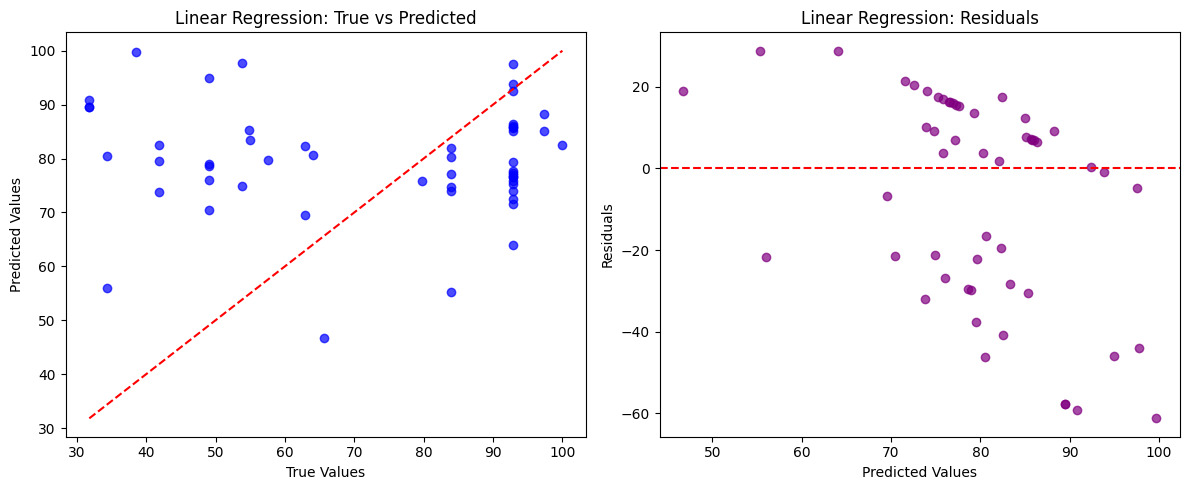


Training Ridge Regression...
Ridge Regression: Selected 18 features: ['PC4', 'PC5', 'PC9', 'PC11', 'PC12', 'PC17', 'PC19', 'PC20', 'PC24', 'PC25', 'PC26', 'PC28', 'PC34', 'PC37', 'PC40', 'PC41', 'PC42', 'PC44']

Ridge Regression:
MSE (Before_features_selection): 531.7409
R² Score (Before_features_selection): -0.0214
MSE (After_features_selection): 532.1264
R² Score (After_features_selection): -0.0222

Actual vs Predicted Data:
Actual: 92.9, Predicted: 77.08056975960196
Actual: 92.9, Predicted: 77.70451483686584
Actual: 92.9, Predicted: 77.02043925952337
Actual: 92.9, Predicted: 78.50304157809892
Actual: 31.8, Predicted: 78.05353072717581
Actual: 84.0, Predicted: 77.4752456376798
Actual: 57.5, Predicted: 77.86243210933661
Actual: 49.1, Predicted: 76.36521756767364
Actual: 92.9, Predicted: 77.46133387594675
Actual: 49.1, Predicted: 75.59824093540755
Actual: 79.7, Predicted: 77.23686464666321
Actual: 49.1, Predicted: 74.82116722585866
Actual: 65.7, Predicted: 77.19016875964789
Actual: 84

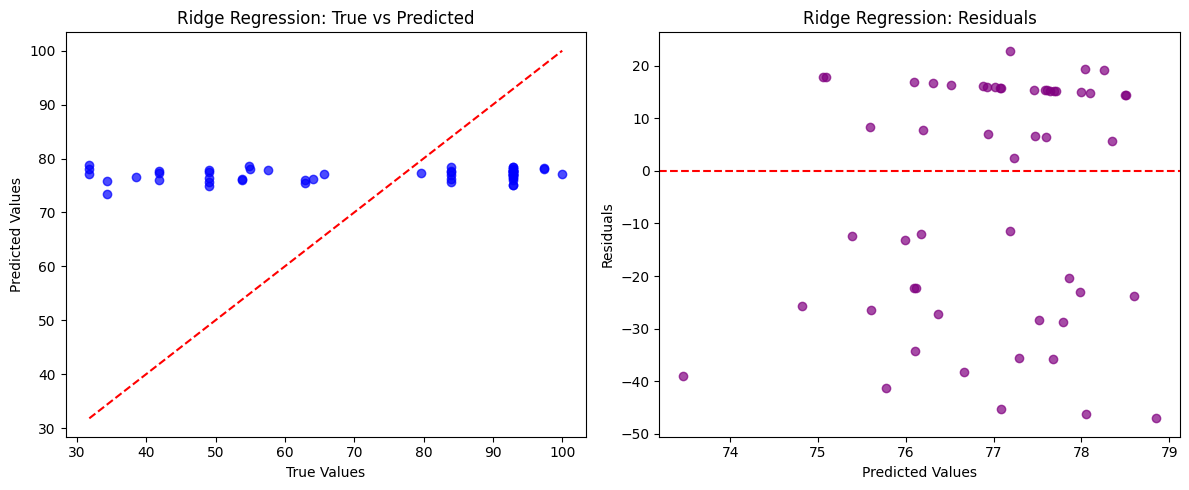


Training Lasso Regression...
Lasso Regression: Selected 45 features: ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC20', 'PC21', 'PC22', 'PC23', 'PC24', 'PC25', 'PC26', 'PC27', 'PC28', 'PC29', 'PC30', 'PC31', 'PC32', 'PC33', 'PC34', 'PC35', 'PC36', 'PC37', 'PC38', 'PC39', 'PC40', 'PC41', 'PC42', 'PC43', 'PC44', 'PC45']

Lasso Regression:
MSE (Before_features_selection): 541.2520
R² Score (Before_features_selection): -0.0397
MSE (After_features_selection): 541.2520
R² Score (After_features_selection): -0.0397

Actual vs Predicted Data:
Actual: 92.9, Predicted: 77.0130081300813
Actual: 92.9, Predicted: 77.0130081300813
Actual: 92.9, Predicted: 77.0130081300813
Actual: 92.9, Predicted: 77.0130081300813
Actual: 31.8, Predicted: 77.0130081300813
Actual: 84.0, Predicted: 77.0130081300813
Actual: 57.5, Predicted: 77.0130081300813
Actual: 49.1, Predicted: 77.0130081300813
Actual: 92.9, Predicte

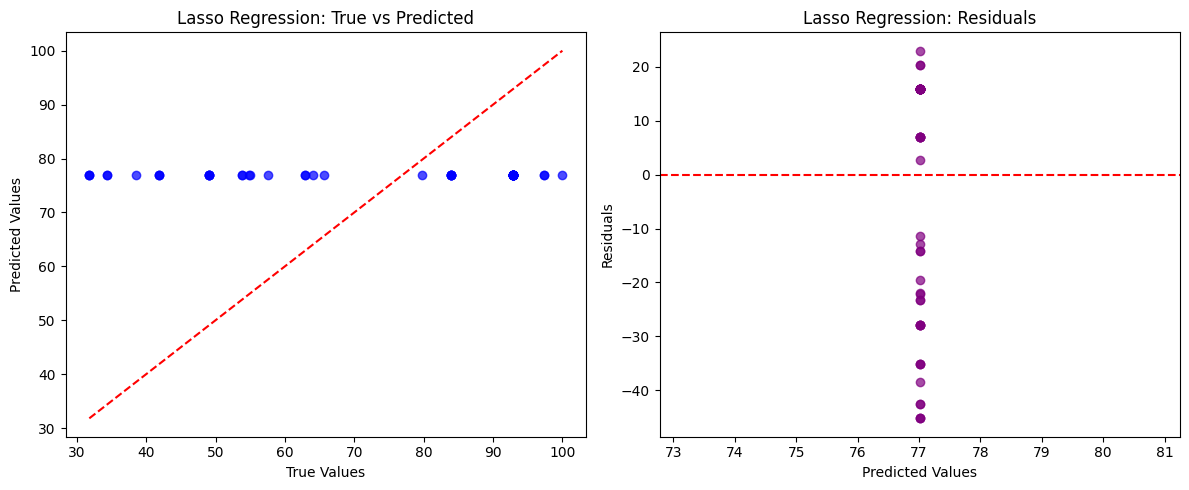


Training Support Vector Regression...
Support Vector Regression: This moodel does not use Feature selection and it deal with all features since there is no differences among them for it . Using all features.

Support Vector Regression:
MSE (Before_features_selection): 658.3301
R² Score (Before_features_selection): -0.2646
MSE (After_features_selection): 658.3301
R² Score (After_features_selection): -0.2646

Actual vs Predicted Data:
Actual: 92.9, Predicted: 85.89691736439264
Actual: 92.9, Predicted: 85.7233823478281
Actual: 92.9, Predicted: 84.2530620141582
Actual: 92.9, Predicted: 86.39950507968739
Actual: 31.8, Predicted: 84.51735911633452
Actual: 84.0, Predicted: 86.46054339610703
Actual: 57.5, Predicted: 86.80320191735134
Actual: 49.1, Predicted: 83.80289658864547
Actual: 92.9, Predicted: 83.93462773971788
Actual: 49.1, Predicted: 83.90623226925189
Actual: 79.7, Predicted: 84.26305091201894
Actual: 49.1, Predicted: 83.05152590863767
Actual: 65.7, Predicted: 85.26138468590813
Actua

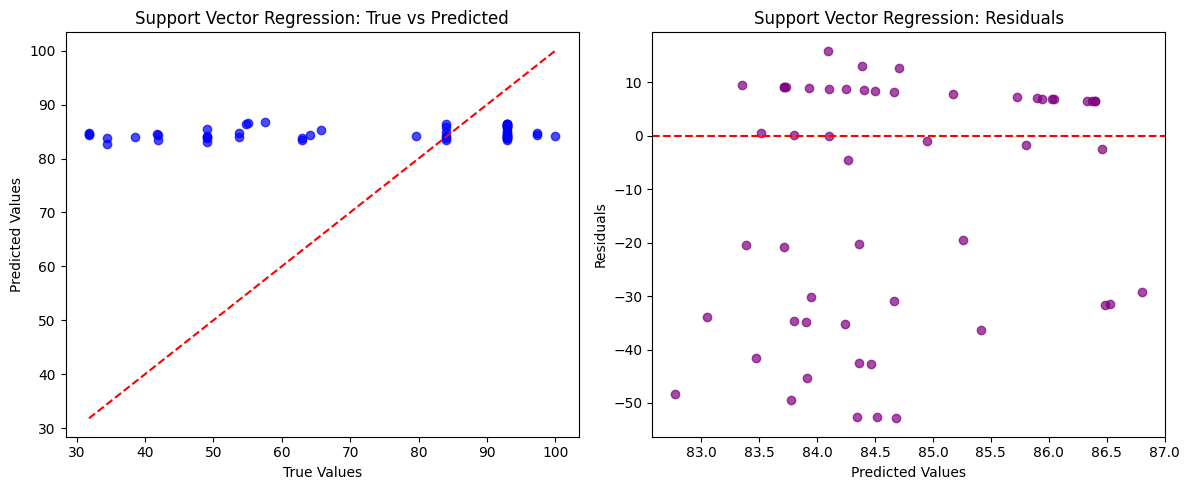


Training Decision Tree Regression...
Decision Tree Regression: Selected 14 features: ['PC2', 'PC4', 'PC5', 'PC6', 'PC11', 'PC21', 'PC26', 'PC27', 'PC29', 'PC30', 'PC33', 'PC36', 'PC40', 'PC41']

Decision Tree Regression:
MSE (Before_features_selection): 791.1923
R² Score (Before_features_selection): -0.5198
MSE (After_features_selection): 781.8317
R² Score (After_features_selection): -0.5018

Actual vs Predicted Data:
Actual: 92.9, Predicted: 92.9
Actual: 92.9, Predicted: 92.9
Actual: 92.9, Predicted: 92.9
Actual: 92.9, Predicted: 92.9
Actual: 31.8, Predicted: 92.9
Actual: 84.0, Predicted: 100.0
Actual: 57.5, Predicted: 84.0
Actual: 49.1, Predicted: 28.7
Actual: 92.9, Predicted: 84.0
Actual: 49.1, Predicted: 92.9
Actual: 79.7, Predicted: 84.0
Actual: 49.1, Predicted: 28.7
Actual: 65.7, Predicted: 97.4
Actual: 84.0, Predicted: 75.0
Actual: 31.8, Predicted: 84.0
Actual: 92.9, Predicted: 92.9
Actual: 41.9, Predicted: 65.7
Actual: 41.9, Predicted: 92.9
Actual: 53.8, Predicted: 34.4
Actual

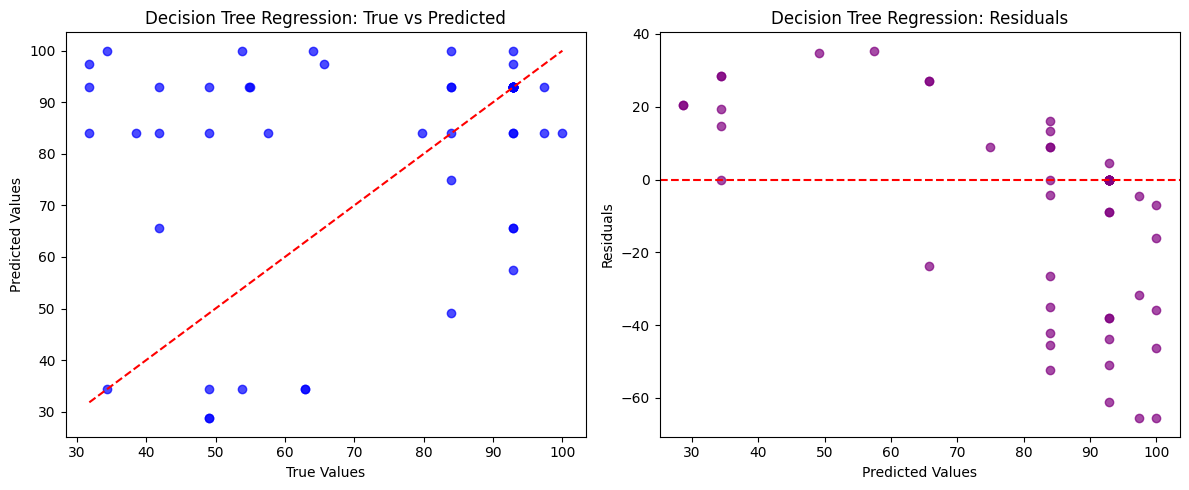


Training Random Forest Regression...
Random Forest Regression: Selected 18 features: ['PC3', 'PC4', 'PC8', 'PC9', 'PC11', 'PC15', 'PC19', 'PC21', 'PC23', 'PC26', 'PC27', 'PC29', 'PC30', 'PC32', 'PC33', 'PC41', 'PC42', 'PC44']

Random Forest Regression:
MSE (Before_features_selection): 493.0530
R² Score (Before_features_selection): 0.0529
MSE (After_features_selection): 500.0406
R² Score (After_features_selection): 0.0395

Actual vs Predicted Data:
Actual: 92.9, Predicted: 78.99099999999997
Actual: 92.9, Predicted: 82.67799999999993
Actual: 92.9, Predicted: 79.01599999999992
Actual: 92.9, Predicted: 80.05299999999993
Actual: 31.8, Predicted: 81.57299999999992
Actual: 84.0, Predicted: 81.50299999999993
Actual: 57.5, Predicted: 78.07399999999994
Actual: 49.1, Predicted: 49.89499999999996
Actual: 92.9, Predicted: 79.20099999999994
Actual: 49.1, Predicted: 76.53899999999994
Actual: 79.7, Predicted: 72.193
Actual: 49.1, Predicted: 70.309
Actual: 65.7, Predicted: 76.14099999999999
Actual: 84

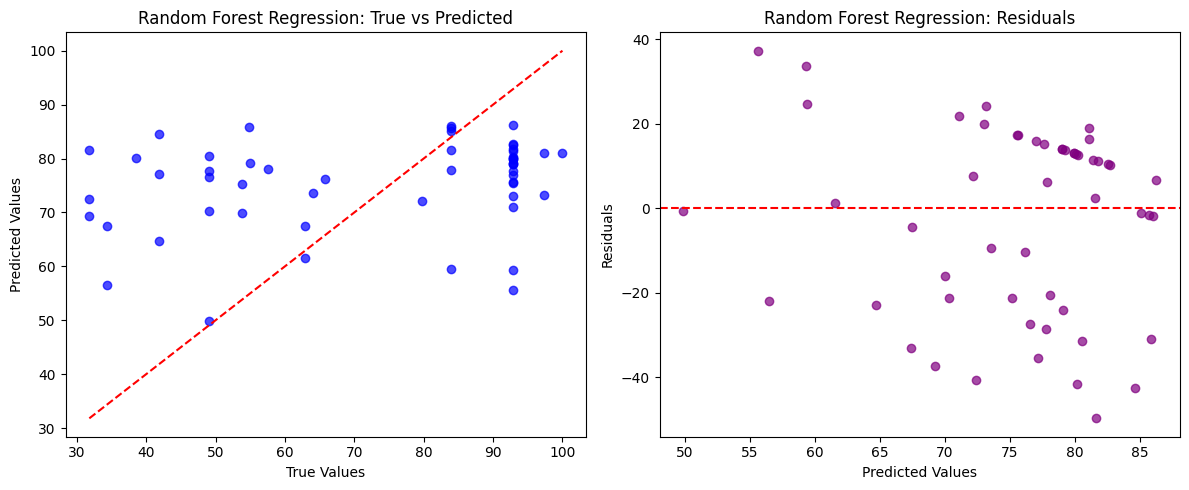


Training Gradient Boosting Regression...
Gradient Boosting Regression: Selected 15 features: ['PC3', 'PC4', 'PC6', 'PC9', 'PC11', 'PC21', 'PC26', 'PC27', 'PC30', 'PC32', 'PC33', 'PC34', 'PC41', 'PC42', 'PC44']

Gradient Boosting Regression:
MSE (Before_features_selection): 525.3108
R² Score (Before_features_selection): -0.0091
MSE (After_features_selection): 561.3602
R² Score (After_features_selection): -0.0783

Actual vs Predicted Data:
Actual: 92.9, Predicted: 78.93313774011463
Actual: 92.9, Predicted: 81.89807566045262
Actual: 92.9, Predicted: 83.07589771911238
Actual: 92.9, Predicted: 67.95123185205978
Actual: 31.8, Predicted: 96.78473417445402
Actual: 84.0, Predicted: 92.73409734840953
Actual: 57.5, Predicted: 75.40751890221708
Actual: 49.1, Predicted: 33.76875410055854
Actual: 92.9, Predicted: 84.18881534532066
Actual: 49.1, Predicted: 79.24035330781126
Actual: 79.7, Predicted: 67.95304477832765
Actual: 49.1, Predicted: 79.1016514283017
Actual: 65.7, Predicted: 70.00743542533618

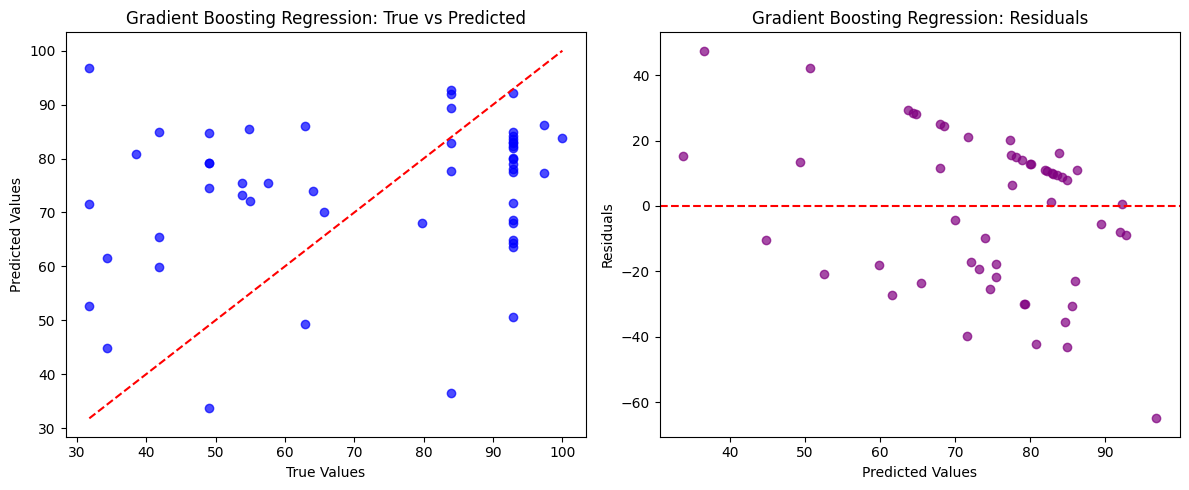


Training K-Nearest Neighbors Regression...
K-Nearest Neighbors Regression: This moodel does not use Feature selection and it deal with all features since there is no differences among them for it . Using all features.

K-Nearest Neighbors Regression:
MSE (Before_features_selection): 620.5278
R² Score (Before_features_selection): -0.1920
MSE (After_features_selection): 620.5278
R² Score (After_features_selection): -0.1920

Actual vs Predicted Data:
Actual: 92.9, Predicted: 86.58
Actual: 92.9, Predicted: 72.02000000000001
Actual: 92.9, Predicted: 81.22
Actual: 92.9, Predicted: 89.26
Actual: 31.8, Predicted: 77.22
Actual: 84.0, Predicted: 83.8
Actual: 57.5, Predicted: 69.78
Actual: 49.1, Predicted: 77.23999999999998
Actual: 92.9, Predicted: 84.8
Actual: 49.1, Predicted: 83.0
Actual: 79.7, Predicted: 88.20000000000002
Actual: 49.1, Predicted: 81.3
Actual: 65.7, Predicted: 96.63999999999999
Actual: 84.0, Predicted: 77.6
Actual: 31.8, Predicted: 81.46000000000001
Actual: 92.9, Predicted: 71

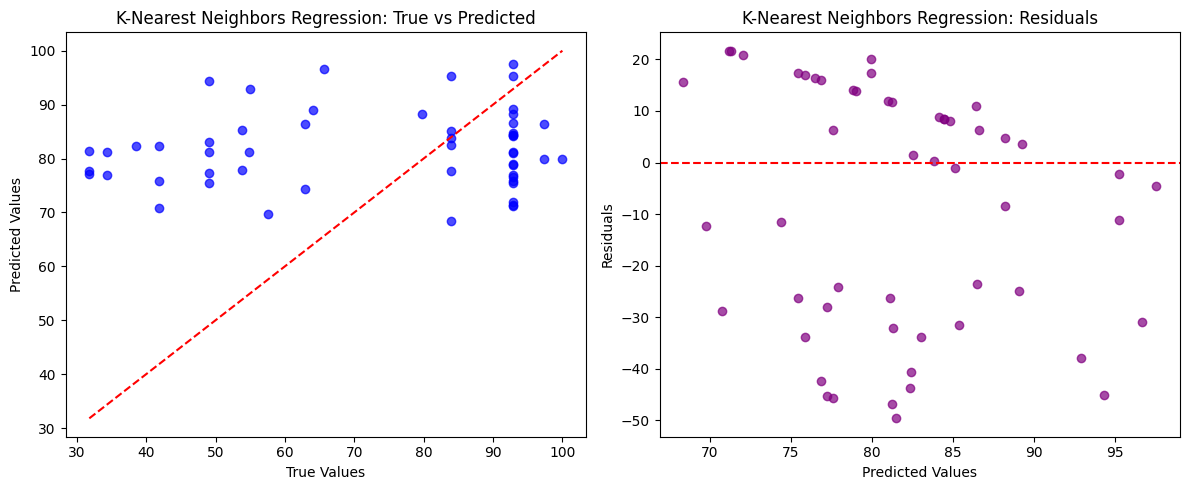


Model Performance Before and After Feature Selection:
                            Model  MSE Before  R² Before   MSE After  \
0               Linear Regression  874.968192  -0.680710  703.977195   
1                Ridge Regression  531.740900  -0.021411  532.126421   
2                Lasso Regression  541.252039  -0.039681  541.252039   
3       Support Vector Regression  658.330090  -0.264574  658.330090   
4        Decision Tree Regression  791.192264  -0.519787  781.831698   
5        Random Forest Regression  493.053025   0.052903  500.040606   
6    Gradient Boosting Regression  525.310754  -0.009060  561.360191   
7  K-Nearest Neighbors Regression  620.527842  -0.191961  620.527842   

   R² After  \
0 -0.352257   
1 -0.022152   
2 -0.039681   
3 -0.264574   
4 -0.501806   
5  0.039481   
6 -0.078307   
7 -0.191961   

                                                                                                                                                                

<ipython-input-32-b6da833886ac>:129: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(mse_scores_before_features_selection.keys()), y=list(mse_scores_before_features_selection.values()), palette='viridis', label='Before')


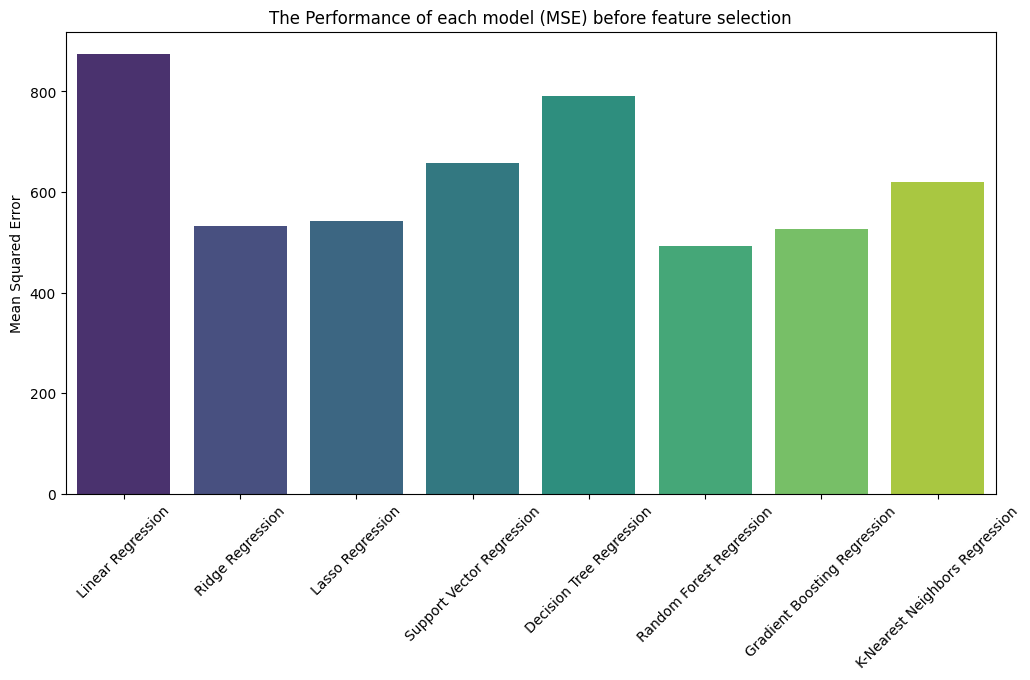

<Figure size 1200x600 with 0 Axes>

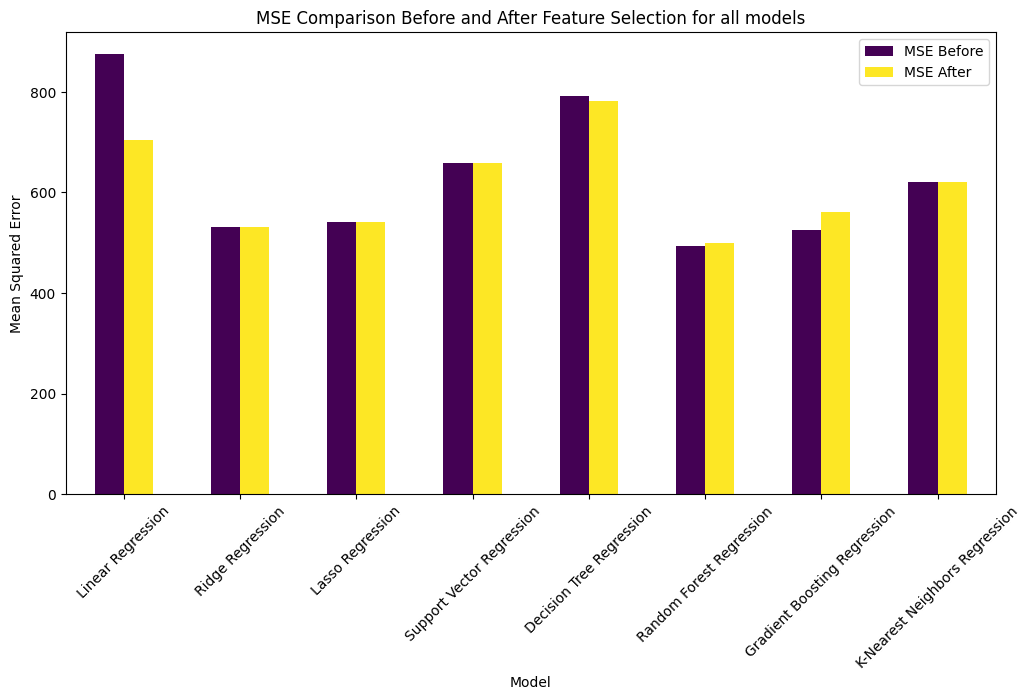


Principal_Component 1:
  inlK: 0.4325
  inlJ: 0.4138
  dltA: 0.3671
  gtcA: 0.3378
  inlB: 0.2899

Principal_Component 2:
  inlF: 0.5610
  lapB: -0.4876
  vip: -0.4615
  prsA2: 0.2372
  hbp2: -0.2243

Principal_Component 3:
  hbp2: 0.8536
  lapB: -0.3070
  inlA: -0.2273
  vip: -0.2106
  aut: -0.1610

Principal_Component 4:
  iap/cwhA: 0.7178
  lapB: 0.3592
  hbp2: 0.3049
  inlF: 0.2808
  inlA: 0.1992

Principal_Component 5:
  prsA2: 0.8238
  ami: -0.2381
  cheA: 0.1906
  inlB: -0.1799
  lapB: 0.1582


In [32]:
all_models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Support Vector Regression": SVR(kernel='rbf'),
    "Decision Tree Regression": DecisionTreeRegressor(),
    "Random Forest Regression": RandomForestRegressor(random_state=0),
    "Gradient Boosting Regression": GradientBoostingRegressor(random_state=0),
    "K-Nearest Neighbors Regression": KNeighborsRegressor()
}

# Perform hyperparameter tuning for Ridge and Lasso
param_grid_lasso = {'alpha': [0.001, 0.01, 0.1, 1, 10]}
grid_lasso = GridSearchCV(Lasso(), param_grid_lasso, scoring='neg_mean_squared_error', cv=5)
grid_lasso.fit(xtrain, ytrain)
print("Best lasso Alpha is :",grid_lasso.best_params_['alpha'])
param_grid_ridge = {'alpha': [0.1, 1, 10, 100]}
grid_ridge = GridSearchCV(Ridge(), param_grid_ridge, scoring='neg_mean_squared_error', cv=5)
grid_ridge.fit(xtrain, ytrain)
print("Best Ridge Alpha is :",grid_ridge.best_params_['alpha'])

# Update models with best parameters
all_models["Lasso Regression"] = Lasso(alpha=grid_lasso.best_params_['alpha'])
all_models["Ridge Regression"] = Ridge(alpha=grid_ridge.best_params_['alpha'])

# Define a custom loss function for clarity (optional)
def loss_function(actual, predicted):
    return np.mean((actual - predicted) ** 2)

# Train and evaluate each model after feature selection
mse_scores_before_features_selection = {}
r2_scores_before_features_selection = {}
mse_scores_after_features_selection = {}
r2_scores_after_features_selection = {}
all_results=[]
for name, model in all_models.items():
    print(f"\nTraining {name}...")

    # model training in all features before features selection
    model.fit(xtrain, ytrain)
    y_pred = model.predict(xtest)
    mse_before = mean_squared_error(ytest, y_pred)
    r2_before = r2_score(ytest, y_pred)
    mse_scores_before_features_selection[name] = mse_before
    r2_scores_before_features_selection[name] = r2_before

    if name in ["Support Vector Regression", "K-Nearest Neighbors Regression"]:
        xtrain_selected = xtrain
        xtest_selected = xtest
        selected_features = []
        print(f"{name}: This moodel does not use Feature selection and it deal with all features since there is no differences among them for it . Using all features.")
    else:
        # features selection using SelectFromModel and splitting features and choosing best features for each model according to mean
        feature_selector = SelectFromModel(model, threshold='mean')
        feature_selector.fit(xtrain, ytrain)
        xtrain_selected = feature_selector.transform(xtrain)
        xtest_selected = feature_selector.transform(xtest)
        # Get selected feature names from PCA transformed data
        selected_features_indices = feature_selector.get_support()
        selected_features = [f"PC{i+1}" for i in range(len(selected_features_indices)) if selected_features_indices[i]]


        print(f"{name}: Selected {len(selected_features)} features: {list(selected_features)}")

    # After feature selection, each model will be trained on the best selected features with it
    model.fit(xtrain_selected, ytrain)
    y_pred = model.predict(xtest_selected)

    # evaluation of models by calculating metrices
    mse_after_features_selection = mean_squared_error(ytest, y_pred)
    r2_after_features_selection = r2_score(ytest, y_pred)
    mse_scores_after_features_selection[name] = mse_after_features_selection
    r2_scores_after_features_selection[name] = r2_after_features_selection

    print(f'\n{name}:\nMSE (Before_features_selection): {mse_before:.4f}\nR² Score (Before_features_selection): {r2_before:.4f}')
    print(f'MSE (After_features_selection): {mse_after_features_selection:.4f}\nR² Score (After_features_selection): {r2_after_features_selection:.4f}')
# Predictied and actual data comparison
    print("\nActual vs Predicted Data:")
    for actual, predicted in zip(ytest, y_pred):
        print(f"Actual: \033[94m{actual}\033[0m, Predicted: \033[91m{predicted}\033[0m")
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(ytest, y_pred, alpha=0.7, color='blue')
    plt.plot([ytest.min(), ytest.max()], [ytest.min(), ytest.max()], 'r--')
    plt.title(f'{name}: True vs Predicted')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')

    # Residual Plot
    plt.subplot(1, 2, 2)
    residuals = ytest - y_pred
    plt.scatter(y_pred, residuals, alpha=0.7, color='purple')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title(f'{name}: Residuals')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')

    plt.tight_layout()
    plt.show()

    # Store results
    all_results.append({
            'Model': name,
            'MSE Before': mse_before,
            'R² Before': r2_before,
            'MSE After': mse_after_features_selection,
            'R² After': r2_after_features_selection,
            'Selected Features': list(selected_features),
           'Feature Names': [feature_names[i] for pc_name in selected_features if pc_name.startswith('PC')
                              # Ensure index is within bounds
                              for i in pca.components_[min(int(pc_name[2:]) - 1, pca.n_components_ - 1)].argsort()[::-1][:len(feature_names)]]
        })

# saving results into a file for further processing
saved_results_df = pd.DataFrame(all_results)
saved_results_df.to_csv('results With PCA.csv', index=False)
# Display the results
print("\nModel Performance Before and After Feature Selection:")
print(saved_results_df)

# Identify the best model
best_model_name_before = min(mse_scores_before_features_selection, key=mse_scores_before_features_selection.get)
best_model_name_after = min(mse_scores_after_features_selection, key=mse_scores_after_features_selection.get)
print(f"\nBest Model (Before): {best_model_name_before} with MSE = {mse_scores_before_features_selection[best_model_name_before]:.4f}, and R² = {r2_scores_before_features_selection[best_model_name_before]:.4f}")
print(f"Best Model (After): {best_model_name_after} with MSE = {mse_scores_after_features_selection[best_model_name_after]:.4f}, and R² = {r2_scores_after_features_selection[best_model_name_after]:.4f}")


plt.figure(figsize=(12, 6))
sns.barplot(x=list(mse_scores_before_features_selection.keys()), y=list(mse_scores_before_features_selection.values()), palette='viridis', label='Before')
plt.title("The Performance of each model (MSE) before feature selection")
plt.ylabel("Mean Squared Error")
plt.xticks(rotation=45)
plt.legend


# MSE Comparison Before and After Feature Selection for all models
plt.figure(figsize=(12, 6))
saved_results_df.set_index('Model')[['MSE Before', 'MSE After']].plot(kind='bar', figsize=(12, 6), colormap='viridis')
plt.title("MSE Comparison Before and After Feature Selection for all models")
plt.ylabel("Mean Squared Error")
plt.xticks(rotation=45)
plt.show()


#features in each pc
loadings = pca.components_

# printing the most top features in each pc
num_top_features = 5

for i, pc in enumerate(loadings):
    top_feature_indices = np.argsort(np.abs(pc))[::-1][:num_top_features]
    top_feature_names = feature_names[top_feature_indices]
    top_feature_loadings = pc[top_feature_indices]
    print(f"\nPrincipal_Component {i + 1}:")
    for name, loading in zip(top_feature_names, top_feature_loadings):
        print(f"  {name}: {loading:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━

<ipython-input-22-a55858a1adde>:83: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', color='black', linewidth=2, label='Perfect Prediction')


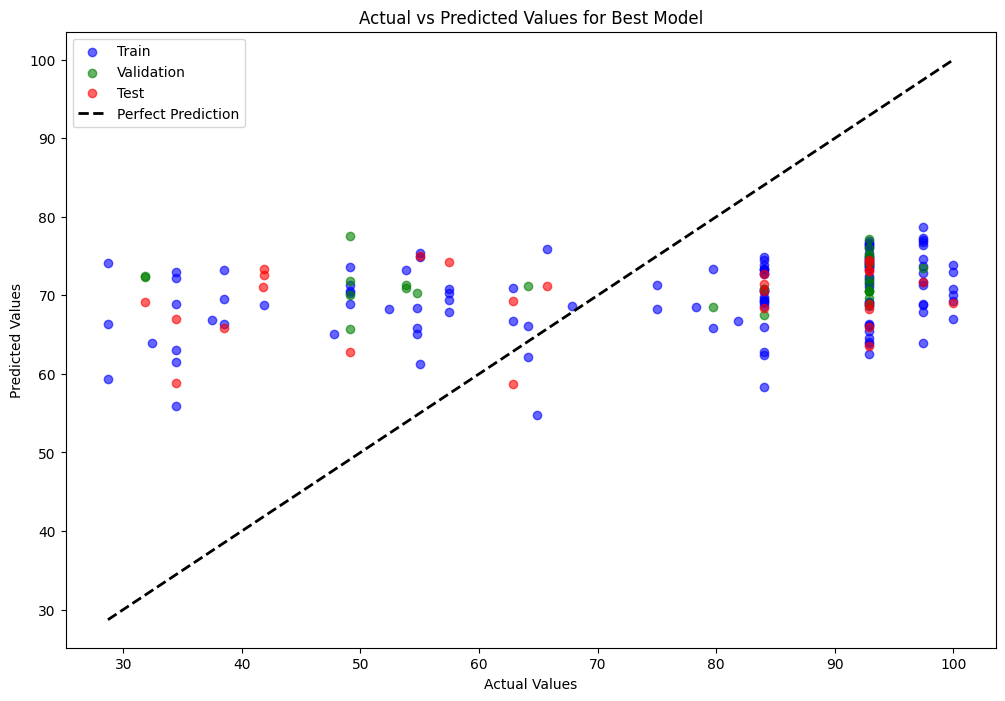

In [22]:
#2--------------------------------------------------NN Hyperparameter tuning
X_val, X_test, y_val, y_test = train_test_split(xtest, ytest, test_size=0.5, random_state=42)

# Define hyperparameter ranges
learning_rates = [0.1, 0.01, 0.001]
activation_functions = ['relu', 'tanh', 'leaky_relu']
num_layers_options = [1, 2, 3]
results = []

# Define a function to build the model
def build_model(layers, activation, learning_rate):
    model = Sequential()
    model.add(Input(shape=(xtrain.shape[1],)))
    for _ in range(layers):
        model.add(Dense(units=128, activation=activation))
    model.add(Dense(1))  # Output layer for regression
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mean_squared_error'
    )
    return model

# Train and evaluate all combinations
for activation, lr, layers in itertools.product(activation_functions, learning_rates, num_layers_options):
    model = build_model(layers, activation, lr)
    history = model.fit(
        xtrain, ytrain,
        epochs=300,
        validation_data=(X_val, y_val),
        callbacks=[EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)],
        verbose=0
    )
    y_pred_test = model.predict(X_test)
    r2 = r2_score(y_test, y_pred_test)
    results.append({
        'activation': activation,
        'learning_rate': lr,
        'num_layers': layers,
        'r2_score': r2
    })

# Organize results into a table
results_df = pd.DataFrame(results)
pivot_table = results_df.pivot_table(
    index='activation',
    columns=['learning_rate', 'num_layers'],
    values='r2_score'
)
print("\nR2 Scores Table:")
print(pivot_table)

# Find the best combination
best_row = results_df.loc[results_df['r2_score'].idxmax()]
print("\nBest Hyperparameter Combination:")
print(best_row)

# Plot Actual vs Predicted for the best combination
best_model = build_model(
    best_row['num_layers'],
    best_row['activation'],
    best_row['learning_rate']
)

# Fit the best model with training data
best_model.fit(
    xtrain, ytrain,  # Correcting to use ytrain for training
    epochs=300,
    validation_data=(X_val, y_val),
    callbacks=[EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)],
    verbose=0
)

# Predictions for the best model
y_pred_train = best_model.predict(xtrain)
y_pred_val = best_model.predict(X_val)
y_pred_test = best_model.predict(X_test)

# Plot actual vs predicted
plt.figure(figsize=(12, 8))
plt.scatter(ytrain, y_pred_train, color='blue', alpha=0.6, label='Train')
plt.scatter(y_val, y_pred_val, color='green', alpha=0.6, label='Validation')
plt.scatter(y_test, y_pred_test, color='red', alpha=0.6, label='Test')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', color='black', linewidth=2, label='Perfect Prediction')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values for Best Model")
plt.legend()
plt.show()


XGBoost Model Performance:
Mean Squared Error (MSE): 554.7863
Root Mean Squared Error (RMSE): 23.5539
R² Score: -0.0657


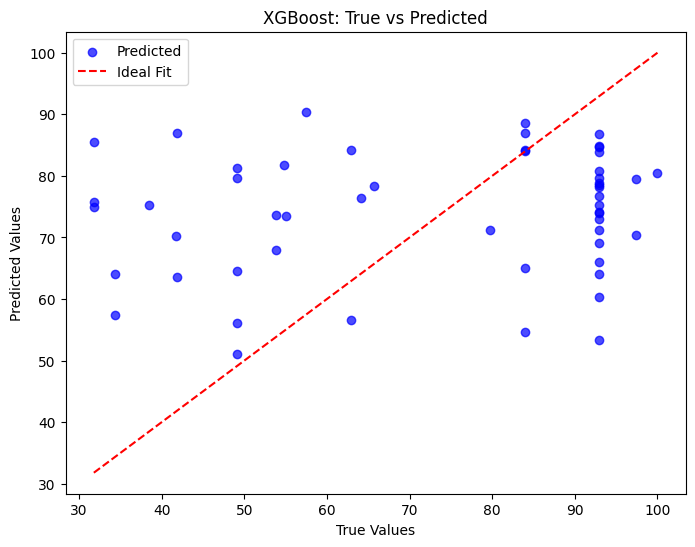

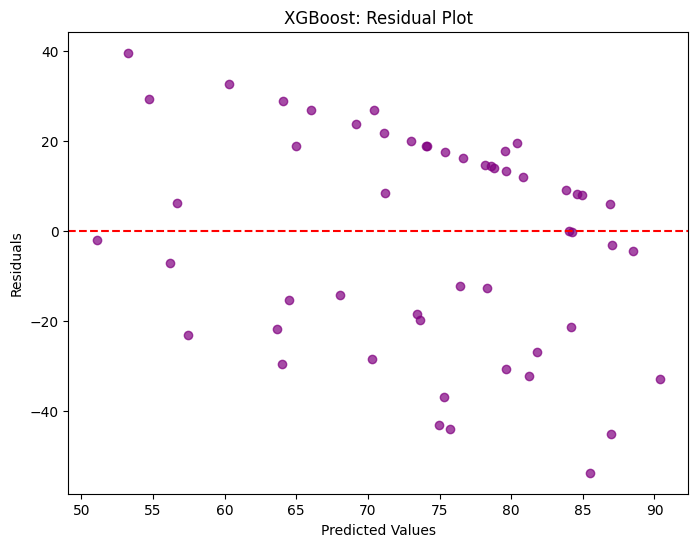

XGBoost MSE: 554.7863
XGBoost RMSE: 23.5539
XGBoost MAE: 20.2090
XGBoost R²: -0.0657


In [26]:


#3----------------------------------------------------XGBoost

xgb_model = XGBRegressor(
    n_estimators=150,  # Number of trees
    learning_rate=0.1,  # Learning rate (eta)
    random_state=42,  # Ensures reproducibility
    max_depth=9,  # Maximum depth of trees
    subsample=0.8,  # Fraction of samples used for fitting
    colsample_bytree=0.8  # Fraction of features considered per tree
)
xgb_model.fit(xtrain, ytrain)

# Make Predictions
y_pred = xgb_model.predict(xtest)

# Evaluate Model Performance
mse = mean_squared_error(ytest, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(ytest, y_pred)

print(f"XGBoost Model Performance:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

# Plot True vs Predicted Values
plt.figure(figsize=(8, 6))
plt.scatter(ytest, y_pred, alpha=0.7, color='blue', label='Predicted')
plt.plot([ytest.min(), ytest.max()], [ytest.min(), ytest.max()], 'r--', label='Ideal Fit')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('XGBoost: True vs Predicted')
plt.legend()
plt.show()

# Plot Residuals
residuals = ytest - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.7, color='purple')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('XGBoost: Residual Plot')
plt.show()

# Predict and Evaluate
xgb_y_pred = xgb_model.predict(xtest)
xgb_mse = mean_squared_error(ytest, xgb_y_pred)
xgb_rmse = np.sqrt(xgb_mse)
xgb_mae = mean_absolute_error(ytest, xgb_y_pred)
xgb_r2 = r2_score(ytest, xgb_y_pred)

# Print Metrics
print(f"XGBoost MSE: {xgb_mse:.4f}")
print(f"XGBoost RMSE: {xgb_rmse:.4f}")
print(f"XGBoost MAE: {xgb_mae:.4f}")
print(f"XGBoost R²: {xgb_r2:.4f}")




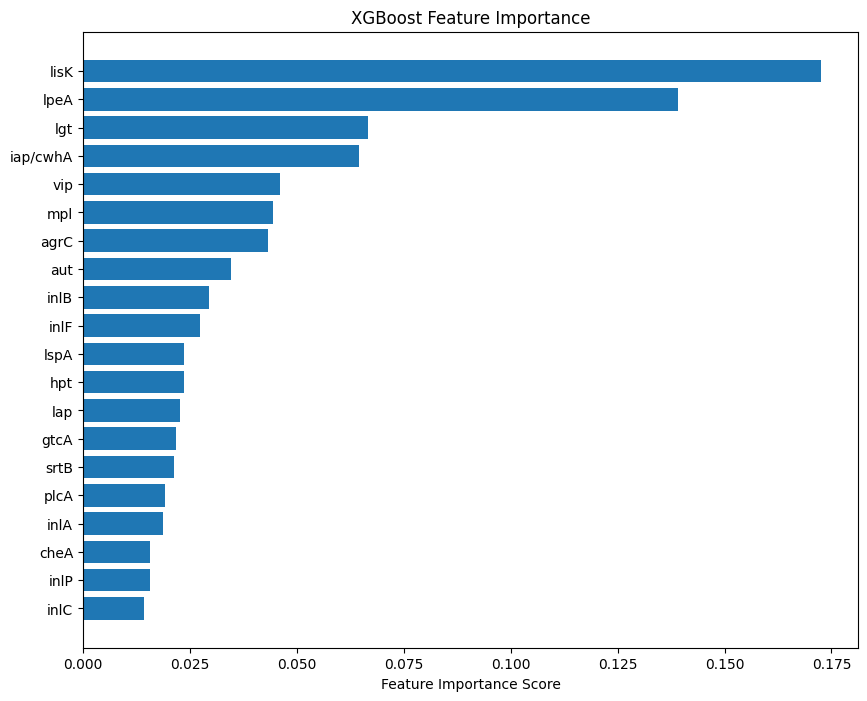

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
    Num Features  \
0              1   
1              2   
2              3   
3              4   
4              5   
5              6   
6              7   
7              8   
8              9   
9             10   
10            11   
11            12   
12            13   
13            14   
14            15   
15            16   
16            17   
17            18   
18            19   
19            20   
20            21   
21            22   
22            23   
23            24   
24            25   
25            26   
26            27   
27            28   
28            29   
29            30   
30            31   
31            32   
32            33   
33            34   
34            35   
35            36   
36            37   
37            38   
38            39   
39            40   
40            41   
41            42   
42            43   
43            44   
44            45   

                                         

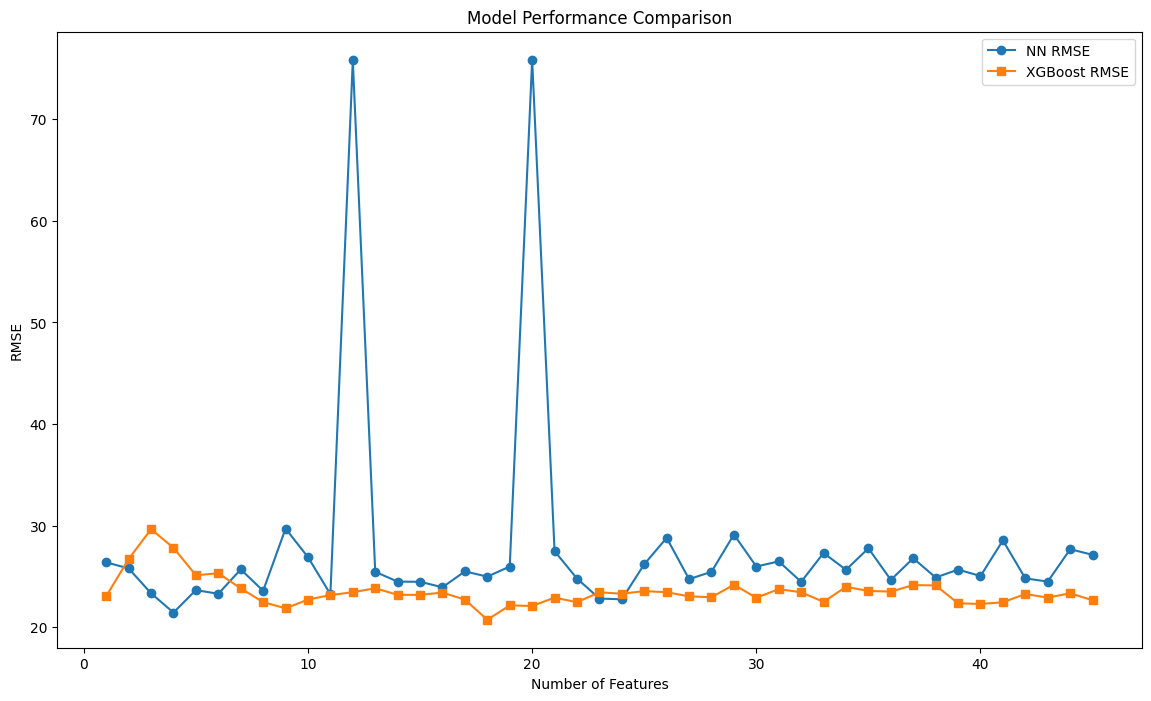

In [20]:
#4----------------------------------------------------XGBoost VS NN
feature_names = X.columns.tolist()

# ---- XGBoost Feature Importance ----
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(xtrain, ytrain)

# Get Feature Importance and Sort
xgb_importances = xgb_model.feature_importances_
sorted_indices = np.argsort(xgb_importances)[::-1]
sorted_feature_names = [feature_names[i] for i in sorted_indices]

# Plot Feature Importance with Feature Names
plt.figure(figsize=(10, 8))
plt.barh(sorted_feature_names[:20][::-1], xgb_importances[sorted_indices[:20][::-1]])
plt.xlabel("Feature Importance Score")
plt.title("XGBoost Feature Importance")
plt.show()

# Initialize Results Storage
results = []

#  Train Models Using Features in Descending Importance
for num_features in range(1, len(sorted_feature_names) + 1):
    # Select Top Features
    top_features = sorted_indices[:num_features]
    X_train_subset = xtrain[:, top_features]
    X_test_subset = xtest[:, top_features]

    # ---- Neural Network ----
    nn_model = Sequential([
        Dense(128, input_dim=X_train_subset.shape[1]),
        LeakyReLU(alpha=0.01),
        BatchNormalization(),
        Dropout(0.3),
        Dense(160),
        LeakyReLU(alpha=0.01),
        BatchNormalization(),
        Dropout(0.3),
        Dense(96),
        LeakyReLU(alpha=0.01),
        BatchNormalization(),
        Dropout(0.2),
        Dense(1)
    ])
    nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                     loss='huber',
                     metrics=['mean_squared_error'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    nn_model.fit(X_train_subset, ytrain,
                 epochs=100,
                 batch_size=16,
                 validation_split=0.2,
                 callbacks=[early_stopping],
                 verbose=0)

    nn_y_pred = nn_model.predict(X_test_subset).flatten()
    nn_mse = mean_squared_error(ytest, nn_y_pred)
    nn_rmse = np.sqrt(nn_mse)
    nn_mae = mean_absolute_error(ytest, nn_y_pred)
    nn_r2 = r2_score(ytest, nn_y_pred)

    # ---- XGBoost ----
    xgb_model = XGBRegressor(
        n_estimators=150,
        learning_rate=0.1,
        random_state=42,
        max_depth=9,
        subsample=0.8,
        colsample_bytree=0.8
    )
    xgb_model.fit(X_train_subset, ytrain)

    xgb_y_pred = xgb_model.predict(X_test_subset)
    xgb_mse = mean_squared_error(ytest, xgb_y_pred)
    xgb_rmse = np.sqrt(xgb_mse)
    xgb_mae = mean_absolute_error(ytest, xgb_y_pred)
    xgb_r2 = r2_score(ytest, xgb_y_pred)

    # Store Results
    results.append({
        'Num Features': num_features,
        'Top Features': ', '.join(sorted_feature_names[:num_features]),
        'NN MSE': nn_mse, 'NN RMSE': nn_rmse, 'NN MAE': nn_mae, 'NN R²': nn_r2,
        'XGB MSE': xgb_mse, 'XGB RMSE': xgb_rmse, 'XGB MAE': xgb_mae, 'XGB R²': xgb_r2
    })

# Convert Results to DataFrame
results_df = pd.DataFrame(results)

# Display Results
pd.set_option('display.max_colwidth', None)  # Ensure feature names are fully displayed
print(results_df)

# Plot Performance Metrics
plt.figure(figsize=(14, 8))
plt.plot(results_df['Num Features'], results_df['NN RMSE'], label='NN RMSE', marker='o')
plt.plot(results_df['Num Features'], results_df['XGB RMSE'], label='XGBoost RMSE', marker='s')
plt.xlabel('Number of Features')
plt.ylabel('RMSE')
plt.title('Model Performance Comparison')
plt.legend()
plt.show()

